In [1]:
import os
import time

import pyreadr as py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, RMSprop
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from torch.utils.tensorboard import SummaryWriter

from sklearn.model_selection import train_test_split

torch.manual_seed(42)
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(device)

cuda:3


> ### Data downloading
Data link  
https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/6C3JR1

##### Data description
Here we consoder dataset of "Additional Tennessee Eastman Process Simulation Data for Anomaly Detection Evaluation"
This dataverse contains the data referenced in Rieth et al. (2017). Issues and Advances in Anomaly Detection Evaluation for Joint Human-Automated Systems. To be presented at Applied Human Factors and Ergonomics 2017.
##### Columns description
* **faultNumber** ranges from 1 to 20 in the “Faulty” datasets and represents the fault type in the TEP. The “FaultFree” datasets only contain fault 0 (i.e. normal operating conditions).
* **simulationRun** ranges from 1 to 500 and represents a different random number generator state from which a full TEP dataset was generated (Note: the actual seeds used to generate training and testing datasets were non-overlapping).
* **sample** ranges either from 1 to 500 (“Training” datasets) or 1 to 960 (“Testing” datasets). The TEP variables (columns 4 to 55) were sampled every 3 minutes for a total duration of 25 hours and 48 hours respectively. Note that the faults were introduced 1 and 8 hours into the Faulty Training and Faulty Testing datasets, respectively.
* **columns 4-55** contain the process variables; the column names retain the original variable names.

In [40]:
# ! unzip ../../data/raw/dataverse_files.zip -d ../../data/raw/dataverse_files

In [41]:
#reading train data in .R format
a1 = py.read_r("../../data/raw/dataverse_files/TEP_FaultFree_Training.RData")
a2 = py.read_r("../../data/raw/dataverse_files/TEP_Faulty_Training.RData")

In [42]:
#reading test data in .R format
a3 = py.read_r("../../data/raw/dataverse_files/TEP_FaultFree_Testing.RData")
a4 = py.read_r("../../data/raw/dataverse_files/TEP_Faulty_Testing.RData")

In [43]:
print("Objects that are present in a1 :", a1.keys())
print("Objects that are present in a2 :", a2.keys())
print("Objects that are present in a3 :", a3.keys())
print("Objects that are present in a4 :", a4.keys())

Objects that are present in a1 : odict_keys(['fault_free_training'])
Objects that are present in a2 : odict_keys(['faulty_training'])
Objects that are present in a3 : odict_keys(['fault_free_testing'])
Objects that are present in a4 : odict_keys(['faulty_testing'])


In [44]:
# concatinating the train and the test dataset

# train dataframe
raw_train = pd.concat([a1['fault_free_training'], a2['faulty_training']])
# test dataframe
raw_test = pd.concat([a3['fault_free_testing'], a4['faulty_testing']])

In [45]:
raw_train['index'] = raw_train['faultNumber'] * 500 + raw_train['simulationRun'] - 1
raw_test['index'] = raw_test['faultNumber'] * 500 + raw_test['simulationRun'] - 1

> ### EDA

In [46]:
features = ['xmeas_1', 'xmeas_2',
       'xmeas_3', 'xmeas_4', 'xmeas_5', 'xmeas_6', 'xmeas_7', 'xmeas_8',
       'xmeas_9', 'xmeas_10', 'xmeas_11', 'xmeas_12', 'xmeas_13', 'xmeas_14',
       'xmeas_15', 'xmeas_16', 'xmeas_17', 'xmeas_18', 'xmeas_19', 'xmeas_20',
       'xmeas_21', 'xmeas_22', 'xmeas_23', 'xmeas_24', 'xmeas_25', 'xmeas_26',
       'xmeas_27', 'xmeas_28', 'xmeas_29', 'xmeas_30', 'xmeas_31', 'xmeas_32',
       'xmeas_33', 'xmeas_34', 'xmeas_35', 'xmeas_36', 'xmeas_37', 'xmeas_38',
       'xmeas_39', 'xmeas_40', 'xmeas_41', 'xmv_1', 'xmv_2', 'xmv_3', 'xmv_4',
       'xmv_5', 'xmv_6', 'xmv_7', 'xmv_8', 'xmv_9', 'xmv_10', 'xmv_11']

In [47]:
def accuracy(y_pred, target):
    
    y_pred = torch.softmax(y_pred, dim=1)
    y_pred = torch.max(y_pred, dim=1)[1]  
    
    return torch.eq(y_pred, target).sum().item()

> ### Sampling

Described in "Data Preparation for Deep Learning Models" in [that article](https://medium.com/@mrunal68/tennessee-eastman-process-simulation-data-for-anomaly-detection-evaluation-d719dc133a7f)

In [48]:
# 5.250.000, 10.080.000
len(raw_train), len(raw_test)

(5250000, 10080000)

In [49]:
simulation_idx = raw_train[['index', 'faultNumber']].drop_duplicates()

In [50]:
X_train_idx, X_val_idx = train_test_split(simulation_idx['index'], 
                                          stratify=simulation_idx['faultNumber'],
                                          test_size=0.2, 
                                          random_state=42)

In [51]:
X_train = raw_train[raw_train['index'].isin(X_train_idx)].drop('index', axis=1)
# y_train = raw_train[raw_train['index'].isin(X_train_idx)][['index', 'faultNumber']]

X_val = raw_train[raw_train['index'].isin(X_val_idx)].drop('index', axis=1)
# y_val = raw_train[raw_train['index'].isin(X_val_idx)][['index', 'faultNumber']]

# X_test = raw_test.drop(['faultNumber', 'simulationRun', 'sample'], axis=1)
# y_test = raw_test['faultNumber']

In [52]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train[features])

X_train[features] = scaler.transform(X_train[features])
X_val[features] = scaler.transform(X_val[features])

In [53]:
# X_raw_train = raw_train[raw_train['faultNumber'].isin([0, 1, 10, 20])].drop('index', axis=1)
X_raw_train = raw_train.drop('index', axis=1)
len(X_raw_train)

5250000

In [54]:
scaler_raw = StandardScaler()
scaler_raw.fit(X_raw_train[features])

X_raw_train[features] = scaler_raw.transform(X_raw_train[features])

In [55]:
class DataTEP(Dataset):

    def __init__(self, X):
    
        self.X = X
        self.X = self.X.sort_values(['faultNumber', 'simulationRun', 'sample'])
        self.X['index'] = self.X.groupby(['faultNumber', 'simulationRun']).ngroup()
        self.X = self.X.set_index('index')

    def __len__(self):
        return self.X.index.max() + 1
    
    def __getitem__(self, idx):
        
        features = [
       'xmeas_1', 'xmeas_2', 'xmeas_3', 'xmeas_4', 'xmeas_5', 'xmeas_6', 'xmeas_7', 'xmeas_8',
       'xmeas_9', 'xmeas_10', 'xmeas_11', 'xmeas_12', 'xmeas_13', 'xmeas_14',
       'xmeas_15', 'xmeas_16', 'xmeas_17', 'xmeas_18', 'xmeas_19', 'xmeas_20',
       'xmeas_21', 'xmeas_22', 'xmeas_23', 'xmeas_24', 'xmeas_25', 'xmeas_26',
       'xmeas_27', 'xmeas_28', 'xmeas_29', 'xmeas_30', 'xmeas_31', 'xmeas_32',
       'xmeas_33', 'xmeas_34', 'xmeas_35', 'xmeas_36', 'xmeas_37', 'xmeas_38',
       'xmeas_39', 'xmeas_40', 'xmeas_41', 'xmv_1', 'xmv_2', 'xmv_3', 'xmv_4',
       'xmv_5', 'xmv_6', 'xmv_7', 'xmv_8', 'xmv_9', 'xmv_10', 'xmv_11']
        
        features = self.X.loc[idx][features].values
        target = self.X.loc[idx]['faultNumber'].unique()[0]
        
#         features = torch.tensor(features, dtype=torch.float)[-10:]
#         features = torch.tensor(features, dtype=torch.float)[:, 0].unsqueeze(-1)
#         features = torch.tensor(features, dtype=torch.float)[-50:, :30]
        features = torch.tensor(features, dtype=torch.float)[-50:, :]
#         features = torch.tensor(features, dtype=torch.float)[:, 1].unsqueeze(-1)
        target = torch.tensor(target, dtype=torch.long)

        return features, target

In [56]:
import gc
gc.collect()

0

In [57]:
BATCH_SIZE = 64
NUM_CLASSES = 21
NUM_EPOCHS = 120
LEARNING_RATE = 0.001

In [58]:
raw_ds = DataTEP(X_raw_train)
raw_dl = DataLoader(raw_ds, batch_size=BATCH_SIZE, shuffle=True)

train_ds = DataTEP(X_train)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

val_ds = DataTEP(X_val)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE*4)

# test_ds = DataTEP(X_test, y_test)
# test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE*4)

In [59]:
def check_dl(dl):
    for (X_batch, y_batch) in tqdm(dl):
        print("min", y_batch.numpy().min())
        print("max", y_batch.numpy().max())
        print(X_batch.size(), y_batch.size())
#         print(np.bincount(y_batch.numpy()))

# check_dl(train_dl)

```python
model_1 = Sequential()
model_1.add(LSTM(256, input_shape=(52, 1), return_sequences=True))
model_1.add(LSTM(128, return_sequences=False))
model_1.add(Dense(300))
model_1.add(Dropout(0.5))
model_1.add(Dense(128))
model_1.add(Dense(21, activation='softmax'))
model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_1.summary())
```

In [60]:
class Model(torch.nn.Module) :
    def __init__(self, NUM_LAYERS, INPUT_SIZE, HIDDEN_SIZE, LINEAR_SIZE, OUTPUT_SIZE, DEVICE):
        super().__init__()
        
        self.hidden_size = HIDDEN_SIZE
        self.num_layers = NUM_LAYERS
        self.input_size = INPUT_SIZE
        self.linear_size = LINEAR_SIZE
        self.output_size = OUTPUT_SIZE
        self.directions = True
        
        self.lstm = nn.LSTM(
                        input_size=self.input_size, 
                        hidden_size=self.hidden_size,
                        num_layers=self.num_layers, 
                        bidirectional=self.directions,
                        batch_first=True,
                        dropout=0.4
            )
        
        self.head = nn.Sequential(
                        nn.Linear(in_features=self.hidden_size*(self.directions+1), out_features=self.linear_size),
                        nn.ReLU(),
                        nn.Dropout(p=0.4),
                        nn.Linear(in_features=self.linear_size, out_features=OUTPUT_SIZE),
            )
        
    def forward(self, x):
        
        x, _ = self.lstm(x)
        x = self.head(x[:, -1])
        
        return x

In [61]:
model = Model(NUM_LAYERS=2, INPUT_SIZE=52, HIDDEN_SIZE=256, LINEAR_SIZE=128, OUTPUT_SIZE=NUM_CLASSES, DEVICE=device)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=30, gamma=0.5)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', verbose=True)

In [62]:
# !rm -r runs

In [64]:
writer = SummaryWriter(comment='cookiecutter')

In [65]:
loss_train_all, loss_val_all = [], []
accuracy_train_all, accuracy_val_all = [], []

for epoch in range(NUM_EPOCHS):

    start = time.time()
    print(f'Epoch: {epoch}, Learning Rate: {scheduler.get_last_lr()[0]}\n')
#     print(f'Epoch: {epoch}\n')

    loss_train_epoch, loss_val_epoch = 0, 0
    correct_train_epoch, correct_val_epoch = 0, 0
    n_train, n_val = 0, 0

    model.train()
    for (X_batch_train, y_batch_train) in tqdm(train_dl):

        X_batch_train, y_batch_train = X_batch_train.to(device), y_batch_train.to(device)

        optimizer.zero_grad()
        y_pred_train = model(X_batch_train)
        loss_train = criterion(y_pred_train, y_batch_train)
        loss_train.backward()
        optimizer.step()

        loss_train_epoch += loss_train.item() * y_batch_train.size()[0]
        correct_train_epoch += accuracy(y_pred_train, y_batch_train)
        n_train += y_batch_train.size()[0]

    scheduler.step()
    model.eval()

    with torch.no_grad():
        
        for item in model.parameters():
            print(item.grad.mean())
        
        for (X_batch_val, y_batch_val) in tqdm(val_dl):

            X_batch_val, y_batch_val = X_batch_val.to(device), y_batch_val.to(device)

            y_pred_val = model(X_batch_val)
            loss_val = criterion(y_pred_val, y_batch_val)
            
            loss_val_epoch += loss_val.item() * y_batch_val.size()[0]
            correct_val_epoch += accuracy(y_pred_val, y_batch_val)
            n_val += y_batch_val.size()[0]
            

    loss_mean_train_epoch = loss_train_epoch / n_train
    loss_mean_val_epoch = loss_val_epoch / n_val

    loss_train_all.append(loss_mean_train_epoch)
    loss_val_all.append(loss_mean_val_epoch)

    accuracy_train_epoch = correct_train_epoch / n_train
    accuracy_val_epoch = correct_val_epoch / n_val

    accuracy_train_all.append(accuracy_train_epoch)
    accuracy_val_all.append(accuracy_val_epoch)

    writer.add_scalars('LOSS per epoch', {"train": loss_mean_train_epoch, "val": loss_mean_val_epoch}, epoch)
    writer.add_scalars('ACCURACY per epoch', {"train": accuracy_train_epoch, "val": accuracy_val_epoch}, epoch)
    
#     scheduler.step(loss_mean_val_epoch)
    
    end = time.time()
    print(f"epoch time: {end - start}")  
    print(f"mean loss train: {loss_mean_train_epoch, loss_train_epoch, n_train}, mean loss val: {loss_mean_val_epoch, loss_val_epoch, n_val}")
    print(f"accuracy train: {accuracy_train_epoch, correct_train_epoch}, accuracy val: {accuracy_val_epoch, correct_val_epoch}")

    print("---------------------------------------------------------------------------------------------------")

Epoch: 0, Learning Rate: 0.001




tensor(-3.3957e-07, device='cuda:3')
tensor(1.9519e-07, device='cuda:3')
tensor(-5.6578e-06, device='cuda:3')
tensor(-5.6578e-06, device='cuda:3')
tensor(4.7111e-08, device='cuda:3')
tensor(-1.9190e-08, device='cuda:3')
tensor(-1.0323e-05, device='cuda:3')
tensor(-1.0323e-05, device='cuda:3')
tensor(-6.8987e-08, device='cuda:3')
tensor(3.4837e-07, device='cuda:3')
tensor(-1.6105e-06, device='cuda:3')
tensor(-1.6105e-06, device='cuda:3')
tensor(1.7769e-07, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-2.6563e-05, device='cuda:3')
tensor(-2.6563e-05, device='cuda:3')
tensor(-3.2220e-06, device='cuda:3')
tensor(6.9289e-05, device='cuda:3')
tensor(-2.5699e-10, device='cuda:3')
tensor(-1.2418e-09, device='cuda:3')



epoch time: 23.022382974624634
mean loss train: (1.9827451024736678, 16655.05886077881, 8400), mean loss val: (1.6324097388131278, 3428.0604515075684, 2100)
accuracy train: (0.34785714285714286, 2922), accuracy val: (0.41285714285714287, 867)
---------------------------------------------------------------------------------------------------
Epoch: 1, Learning Rate: 0.001




tensor(-1.7921e-06, device='cuda:3')
tensor(-5.4946e-07, device='cuda:3')
tensor(-4.7688e-05, device='cuda:3')
tensor(-4.7688e-05, device='cuda:3')
tensor(-6.5783e-07, device='cuda:3')
tensor(-1.3536e-06, device='cuda:3')
tensor(0.0002, device='cuda:3')
tensor(0.0002, device='cuda:3')
tensor(-5.0468e-08, device='cuda:3')
tensor(-1.1961e-06, device='cuda:3')
tensor(-2.9825e-05, device='cuda:3')
tensor(-2.9825e-05, device='cuda:3')
tensor(5.2205e-08, device='cuda:3')
tensor(0., device='cuda:3')
tensor(2.2939e-05, device='cuda:3')
tensor(2.2939e-05, device='cuda:3')
tensor(-5.3232e-06, device='cuda:3')
tensor(8.9609e-05, device='cuda:3')
tensor(-2.8576e-09, device='cuda:3')
tensor(-3.0157e-09, device='cuda:3')



epoch time: 22.961378574371338
mean loss train: (1.6068167983917963, 13497.261106491089, 8400), mean loss val: (1.515057562873477, 3181.6208820343018, 2100)
accuracy train: (0.43357142857142855, 3642), accuracy val: (0.47, 987)
---------------------------------------------------------------------------------------------------
Epoch: 2, Learning Rate: 0.001




tensor(-3.0428e-05, device='cuda:3')
tensor(-8.0769e-06, device='cuda:3')
tensor(-0.0002, device='cuda:3')
tensor(-0.0002, device='cuda:3')
tensor(1.4919e-05, device='cuda:3')
tensor(-1.0062e-06, device='cuda:3')
tensor(-0.0002, device='cuda:3')
tensor(-0.0002, device='cuda:3')
tensor(-5.6166e-07, device='cuda:3')
tensor(3.4750e-07, device='cuda:3')
tensor(2.3153e-05, device='cuda:3')
tensor(2.3153e-05, device='cuda:3')
tensor(2.7746e-07, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-3.8993e-05, device='cuda:3')
tensor(-3.8993e-05, device='cuda:3')
tensor(8.5742e-06, device='cuda:3')
tensor(0.0005, device='cuda:3')
tensor(2.7319e-09, device='cuda:3')
tensor(-1.2418e-09, device='cuda:3')



epoch time: 24.35924458503723
mean loss train: (1.2460100210280645, 10466.484176635742, 8400), mean loss val: (0.9011474223363967, 1892.409586906433, 2100)
accuracy train: (0.5561904761904762, 4672), accuracy val: (0.6647619047619048, 1396)
---------------------------------------------------------------------------------------------------
Epoch: 3, Learning Rate: 0.001




tensor(1.8144e-05, device='cuda:3')
tensor(-6.6954e-06, device='cuda:3')
tensor(0.0003, device='cuda:3')
tensor(0.0003, device='cuda:3')
tensor(-1.2255e-05, device='cuda:3')
tensor(8.1275e-08, device='cuda:3')
tensor(0.0004, device='cuda:3')
tensor(0.0004, device='cuda:3')
tensor(6.2365e-07, device='cuda:3')
tensor(-2.2879e-06, device='cuda:3')
tensor(-8.5570e-05, device='cuda:3')
tensor(-8.5570e-05, device='cuda:3')
tensor(-7.3521e-08, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-0.0001, device='cuda:3')
tensor(-0.0001, device='cuda:3')
tensor(-9.2189e-06, device='cuda:3')
tensor(-0.0006, device='cuda:3')
tensor(5.7415e-11, device='cuda:3')
tensor(1.0644e-09, device='cuda:3')



epoch time: 22.74419093132019
mean loss train: (0.9820533118929182, 8249.247819900513, 8400), mean loss val: (0.8145330875828153, 1710.519483923912, 2100)
accuracy train: (0.6290476190476191, 5284), accuracy val: (0.6795238095238095, 1427)
---------------------------------------------------------------------------------------------------
Epoch: 4, Learning Rate: 0.001




tensor(-5.3282e-06, device='cuda:3')
tensor(5.3938e-07, device='cuda:3')
tensor(6.4142e-05, device='cuda:3')
tensor(6.4142e-05, device='cuda:3')
tensor(-1.6432e-06, device='cuda:3')
tensor(3.7736e-07, device='cuda:3')
tensor(0.0002, device='cuda:3')
tensor(0.0002, device='cuda:3')
tensor(6.4685e-07, device='cuda:3')
tensor(-1.5179e-06, device='cuda:3')
tensor(-0.0001, device='cuda:3')
tensor(-0.0001, device='cuda:3')
tensor(4.4887e-07, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-3.2090e-05, device='cuda:3')
tensor(-3.2090e-05, device='cuda:3')
tensor(-4.0460e-06, device='cuda:3')
tensor(-0.0004, device='cuda:3')
tensor(2.1876e-10, device='cuda:3')
tensor(-5.3218e-10, device='cuda:3')



epoch time: 22.580911874771118
mean loss train: (0.7418901007516043, 6231.876846313477, 8400), mean loss val: (0.5876076596975327, 1233.9760853648186, 2100)
accuracy train: (0.7171428571428572, 6024), accuracy val: (0.7576190476190476, 1591)
---------------------------------------------------------------------------------------------------
Epoch: 5, Learning Rate: 0.001




tensor(-0.0005, device='cuda:3')
tensor(-6.6230e-05, device='cuda:3')
tensor(0.0247, device='cuda:3')
tensor(0.0247, device='cuda:3')
tensor(4.8835e-05, device='cuda:3')
tensor(-1.1815e-07, device='cuda:3')
tensor(-0.0007, device='cuda:3')
tensor(-0.0007, device='cuda:3')
tensor(3.8334e-06, device='cuda:3')
tensor(1.8054e-06, device='cuda:3')
tensor(-0.0017, device='cuda:3')
tensor(-0.0017, device='cuda:3')
tensor(1.9296e-07, device='cuda:3')
tensor(0., device='cuda:3')
tensor(0.0002, device='cuda:3')
tensor(0.0002, device='cuda:3')
tensor(-3.3341e-06, device='cuda:3')
tensor(0.0006, device='cuda:3')
tensor(7.0717e-09, device='cuda:3')
tensor(4.4349e-09, device='cuda:3')



epoch time: 23.441087007522583
mean loss train: (0.5740104487964085, 4821.6877698898315, 8400), mean loss val: (0.6163847897379171, 1294.408058449626, 2100)
accuracy train: (0.7660714285714286, 6435), accuracy val: (0.74, 1554)
---------------------------------------------------------------------------------------------------
Epoch: 6, Learning Rate: 0.001




tensor(6.8223e-05, device='cuda:3')
tensor(-1.4111e-06, device='cuda:3')
tensor(-0.0016, device='cuda:3')
tensor(-0.0016, device='cuda:3')
tensor(3.0112e-05, device='cuda:3')
tensor(-4.1754e-07, device='cuda:3')
tensor(-0.0003, device='cuda:3')
tensor(-0.0003, device='cuda:3')
tensor(-1.7096e-07, device='cuda:3')
tensor(-4.8649e-06, device='cuda:3')
tensor(0.0002, device='cuda:3')
tensor(0.0002, device='cuda:3')
tensor(1.9603e-07, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-6.3378e-05, device='cuda:3')
tensor(-6.3378e-05, device='cuda:3')
tensor(-4.1382e-07, device='cuda:3')
tensor(0.0001, device='cuda:3')
tensor(-1.2963e-09, device='cuda:3')
tensor(-2.6609e-10, device='cuda:3')



epoch time: 23.146653175354004
mean loss train: (0.5774836363111223, 4850.862545013428, 8400), mean loss val: (0.645815856783163, 1356.2132992446423, 2100)
accuracy train: (0.7667857142857143, 6441), accuracy val: (0.7385714285714285, 1551)
---------------------------------------------------------------------------------------------------
Epoch: 7, Learning Rate: 0.001




tensor(8.7084e-06, device='cuda:3')
tensor(-1.9711e-06, device='cuda:3')
tensor(0.0005, device='cuda:3')
tensor(0.0005, device='cuda:3')
tensor(-4.7475e-06, device='cuda:3')
tensor(6.4976e-07, device='cuda:3')
tensor(0.0001, device='cuda:3')
tensor(0.0001, device='cuda:3')
tensor(-3.1177e-07, device='cuda:3')
tensor(-4.4137e-06, device='cuda:3')
tensor(-0.0002, device='cuda:3')
tensor(-0.0002, device='cuda:3')
tensor(3.1622e-08, device='cuda:3')
tensor(0., device='cuda:3')
tensor(1.3894e-05, device='cuda:3')
tensor(1.3894e-05, device='cuda:3')
tensor(-3.3726e-06, device='cuda:3')
tensor(-0.0003, device='cuda:3')
tensor(-2.4666e-09, device='cuda:3')
tensor(-3.7253e-09, device='cuda:3')



epoch time: 22.603814601898193
mean loss train: (0.49731302613303774, 4177.429419517517, 8400), mean loss val: (0.466291528882104, 979.2122106524184, 2100)
accuracy train: (0.7846428571428572, 6591), accuracy val: (0.7980952380952381, 1676)
---------------------------------------------------------------------------------------------------
Epoch: 8, Learning Rate: 0.001




tensor(-3.3446e-06, device='cuda:3')
tensor(2.9201e-07, device='cuda:3')
tensor(-4.2017e-05, device='cuda:3')
tensor(-4.2017e-05, device='cuda:3')
tensor(9.9351e-06, device='cuda:3')
tensor(1.1749e-07, device='cuda:3')
tensor(-2.0111e-05, device='cuda:3')
tensor(-2.0111e-05, device='cuda:3')
tensor(1.6964e-07, device='cuda:3')
tensor(3.1924e-06, device='cuda:3')
tensor(-0.0001, device='cuda:3')
tensor(-0.0001, device='cuda:3')
tensor(-9.2112e-08, device='cuda:3')
tensor(0., device='cuda:3')
tensor(2.1395e-05, device='cuda:3')
tensor(2.1395e-05, device='cuda:3')
tensor(-3.2544e-06, device='cuda:3')
tensor(9.3397e-05, device='cuda:3')
tensor(-2.6814e-09, device='cuda:3')
tensor(-7.0958e-10, device='cuda:3')



epoch time: 22.45883584022522
mean loss train: (0.4486537106831868, 3768.6911697387695, 8400), mean loss val: (0.43496318726323635, 913.4226932527963, 2100)
accuracy train: (0.8001190476190476, 6721), accuracy val: (0.8019047619047619, 1684)
---------------------------------------------------------------------------------------------------
Epoch: 9, Learning Rate: 0.001




tensor(6.7131e-06, device='cuda:3')
tensor(2.7361e-06, device='cuda:3')
tensor(-0.0027, device='cuda:3')
tensor(-0.0027, device='cuda:3')
tensor(2.1486e-05, device='cuda:3')
tensor(-1.4674e-07, device='cuda:3')
tensor(-0.0008, device='cuda:3')
tensor(-0.0008, device='cuda:3')
tensor(-9.8708e-07, device='cuda:3')
tensor(-1.1550e-05, device='cuda:3')
tensor(1.2602e-05, device='cuda:3')
tensor(1.2602e-05, device='cuda:3')
tensor(-1.4211e-07, device='cuda:3')
tensor(0., device='cuda:3')
tensor(4.8550e-05, device='cuda:3')
tensor(4.8550e-05, device='cuda:3')
tensor(1.2623e-06, device='cuda:3')
tensor(-0.0011, device='cuda:3')
tensor(-2.6496e-09, device='cuda:3')
tensor(-1.0644e-09, device='cuda:3')



epoch time: 22.749714612960815
mean loss train: (0.42440684329895745, 3565.0174837112427, 8400), mean loss val: (0.4510331346877917, 947.1695828443626, 2100)
accuracy train: (0.8064285714285714, 6774), accuracy val: (0.7961904761904762, 1672)
---------------------------------------------------------------------------------------------------
Epoch: 10, Learning Rate: 0.001




tensor(6.1096e-07, device='cuda:3')
tensor(9.5554e-07, device='cuda:3')
tensor(9.8175e-05, device='cuda:3')
tensor(9.8175e-05, device='cuda:3')
tensor(-5.6432e-06, device='cuda:3')
tensor(-1.1849e-07, device='cuda:3')
tensor(7.3332e-05, device='cuda:3')
tensor(7.3332e-05, device='cuda:3')
tensor(2.2351e-08, device='cuda:3')
tensor(-6.0658e-07, device='cuda:3')
tensor(-9.7901e-05, device='cuda:3')
tensor(-9.7901e-05, device='cuda:3')
tensor(-3.9753e-09, device='cuda:3')
tensor(0., device='cuda:3')
tensor(3.7265e-06, device='cuda:3')
tensor(3.7265e-06, device='cuda:3')
tensor(-5.2550e-06, device='cuda:3')
tensor(-0.0003, device='cuda:3')
tensor(-4.2390e-09, device='cuda:3')
tensor(-2.4835e-09, device='cuda:3')



epoch time: 22.817238092422485
mean loss train: (0.45844464438302174, 3850.935012817383, 8400), mean loss val: (0.4192122191483421, 880.3456602115184, 2100)
accuracy train: (0.799047619047619, 6712), accuracy val: (0.8023809523809524, 1685)
---------------------------------------------------------------------------------------------------
Epoch: 11, Learning Rate: 0.001




tensor(-2.6002e-06, device='cuda:3')
tensor(-3.4452e-07, device='cuda:3')
tensor(0.0001, device='cuda:3')
tensor(0.0001, device='cuda:3')
tensor(2.2896e-07, device='cuda:3')
tensor(1.5871e-08, device='cuda:3')
tensor(-1.4650e-05, device='cuda:3')
tensor(-1.4650e-05, device='cuda:3')
tensor(-7.9897e-08, device='cuda:3')
tensor(1.9676e-06, device='cuda:3')
tensor(3.8430e-05, device='cuda:3')
tensor(3.8430e-05, device='cuda:3')
tensor(6.2458e-08, device='cuda:3')
tensor(0., device='cuda:3')
tensor(-2.2037e-05, device='cuda:3')
tensor(-2.2037e-05, device='cuda:3')
tensor(3.7600e-06, device='cuda:3')
tensor(0.0001, device='cuda:3')
tensor(4.7867e-09, device='cuda:3')
tensor(3.1931e-09, device='cuda:3')



epoch time: 22.86341905593872
mean loss train: (0.3867828340189797, 3248.97580575943, 8400), mean loss val: (0.4071257997696133, 854.9641795161879, 2100)
accuracy train: (0.8128571428571428, 6828), accuracy val: (0.8028571428571428, 1686)
---------------------------------------------------------------------------------------------------
Epoch: 12, Learning Rate: 0.001



KeyboardInterrupt: 

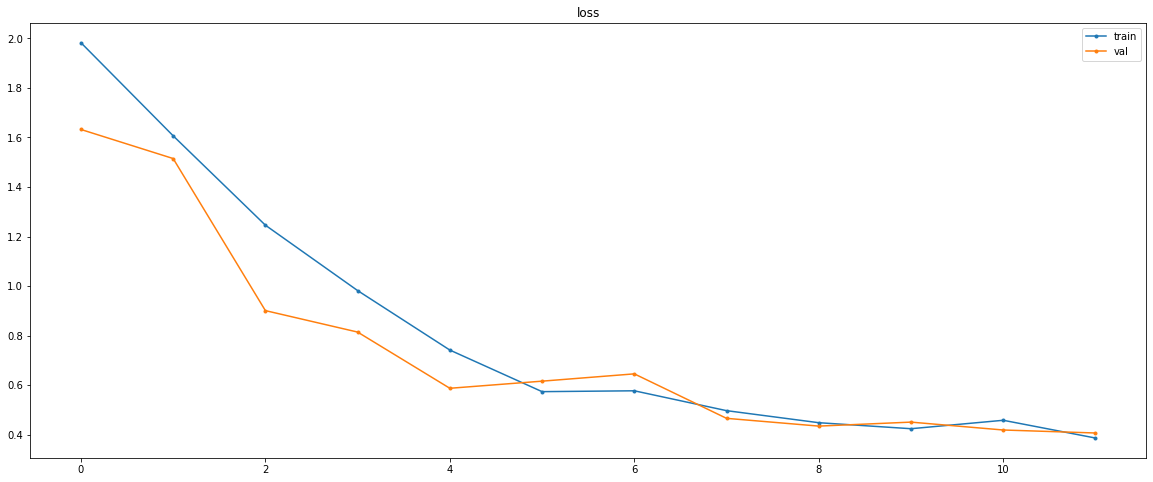

In [66]:
plt.figure(figsize=(20, 8))
plt.title("loss")
plt.plot(np.arange(len(loss_train_all)), loss_train_all, '-o', marker='.', label='train')
plt.plot(np.arange(len(loss_val_all)), loss_val_all, '-o', marker='.', label='val')
plt.legend()
plt.show()

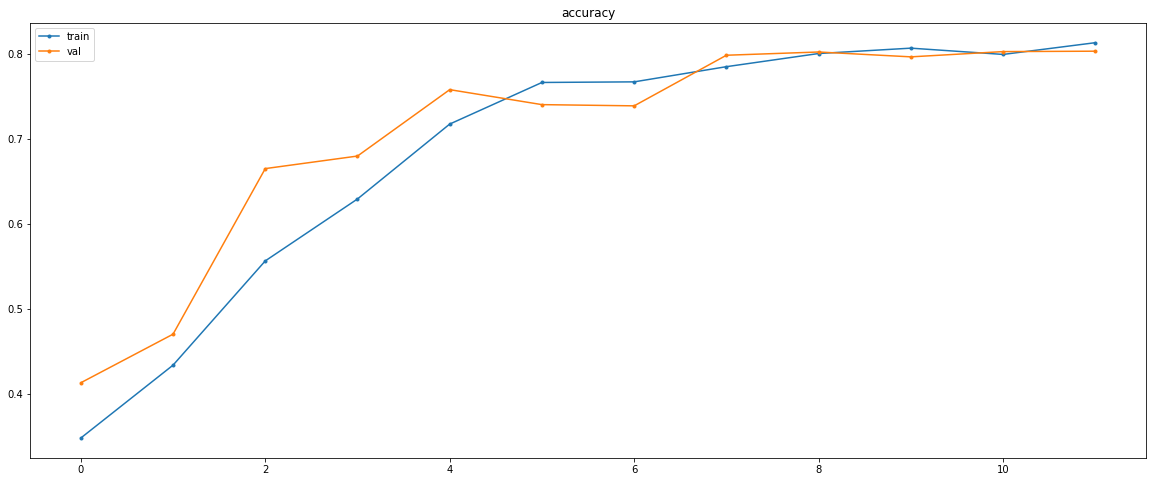

In [67]:
plt.figure(figsize=(20, 8))
plt.title("accuracy")
plt.plot(np.arange(len(accuracy_train_all)), accuracy_train_all, '-o', marker='.', label='train')
plt.plot(np.arange(len(accuracy_val_all)), accuracy_val_all, '-o', marker='.', label='val')
plt.legend()
plt.show()

# ----------------------------------------------------------------------------------------